## Reinforcement Learning Agent
 By Liang-Ying Chih (last edited May 2, 2022)

# Formalism: Double DQN

[van Hasselt et al., "Deep Reinforcement Learning with Double Q-learning." arXiv preprint arXiv:1509.06461, 2015.](https://arxiv.org/pdf/1509.06461.pdf)

In double Q-learning, there is a regular Q-network $\theta$ and an extra network called target netowrk $\theta'$. The regular Q-network is used for action selection, and the target network is used to evaluate the future optimal return. The target network is only updated more slowly through a weighted average. This avoids the unstable feedback since the Q-network and target network are weakly correlated at early stages of the learning process. Furthermore, this method also resolves issues with overoptimism in the standard deep Q-learning algorithm.
The return can then be written as

$$
Y_t = r_{t+1} + \gamma Q(s_{t+1}, \arg\max_a Q(s_{t+1}, a; \theta); \theta').
$$

To compare deep Q-learning and double deep Q-learning, let's take a look at the code:

##### DQN:

```
target = reward + gamma * dqn_target(next_state).max(dim=1, keepdim=True)[0]
```

##### DoubleDQN:

```
selected_action = dqn(next_state).argmax(dim=1, keepdim=True)
target = reward + gamma * dqn_target(next_state).gather(1, selected_action)
```
      

In [1]:
import os
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

from environment_sensor import Env

## Replay buffer

In [2]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size

## Network

We are going to use a simple network architecture with three fully connected layers and two non-linearity functions (ReLU).

In [3]:
class Network(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        """Initialization."""
        super(Network, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_dim, 32), 
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, out_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        return self.layers(x)

## Double DQN Agent

Here is a summary of DQNAgent class.

| Method           | Note                                                 |
| ---              | ---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|compute_dqn_loss  | return dqn loss.                                     |
|update_model      | update the model by gradient descent.                |
|target_hard_update| hard update from the local model to the target model.|
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|plot              | plot the training progresses.                        |

We use `self.dqn` instead of `self.dqn_target` for action selection.

```

        next_q_value = self.dqn_target(next_state).gather(
            1, self.dqn(next_state).argmax(dim=1, keepdim=True)  # Double DQN
        ).detach()
        mask = 1 - done
        target = (reward + self.gamma * next_q_value * mask).to(self.device)
```

In [4]:
class DQNAgent:
    """DQN Agent interacting with environment.
    
    Attribute:
        env (Env): self-defined environment
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        epsilon (float): parameter for epsilon greedy policy
        epsilon_decay (float): step size to decrease epsilon
        max_epsilon (float): max value of epsilon
        min_epsilon (float): min value of epsilon
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including 
                           state, action, reward, next_state, done
    """

    def __init__(
        self, 
        env: Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        epsilon_decay: float,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.02,
        gamma: float = 0.99,
        alpha: float = 0.0002,
    ):
        """Initialization.
        
        Args:
            env (Env): self-defined environment
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            target_update (int): period for target model's hard update
            epsilon_decay (float): step size to decrease epsilon
            lr (float): learning rate
            max_epsilon (float): max value of epsilon
            min_epsilon (float): min value of epsilon
            gamma (float): discount factor
        """
        obs_dim = env.n_states 
        action_dim = env.n_actions 
        
        self.env = env
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.target_update = target_update
        self.gamma = gamma
        self.alpha = alpha
        
        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        # networks: dqn, dqn_target
        self.dqn = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()
        
        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters(), lr=self.alpha)

        # transition to store in memory
        self.transition = list()
        
        # mode: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # epsilon greedy policy
        if self.epsilon > np.random.random():
            selected_action = np.random.choice(range(self.env.n_actions))
        else:
            selected_action = self.dqn(
                torch.FloatTensor(state).to(self.device)
            ).argmax()
            selected_action = selected_action.detach().cpu().numpy()
        
        if not self.is_test:
            self.transition = [state, selected_action]
        
        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done, fid = self.env.step(action)
        
        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)
    
        return next_state, reward, done

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        samples = self.memory.sample_batch()

        loss = self._compute_dqn_loss(samples)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()
        
    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False
        
        state = self.env.reset()
        update_cnt = 0
        epsilons = []
        losses = []
        scores = []
        score = 0

        for frame_idx in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            # if episode ends
            if done:
                state = self.env.reset()
                scores.append(score)
                score = 0

            # if training is ready
            if len(self.memory) >= self.batch_size*6:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1
                
                # linearly decrease epsilon
                self.epsilon = max(
                    self.min_epsilon, self.epsilon * (1. - self.epsilon_decay)
                )
                epsilons.append(self.epsilon)
                
                # if hard update is needed
                # if update_cnt % self.target_update == 0:
                #    self._target_hard_update()
                self._target_soft_update(0.999)

            # plotting
            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx, scores, losses, epsilons)
                
                
    def test(self) -> List[np.ndarray]:
        """Test the agent."""
        self.is_test = True
        
        state = self.env.reset()
        done = False
        score = 0
        
        frames = []
        c = 0
        while not done:
            action = self.select_action(state)
            c += 1
            next_state, reward, done, fid = self.env.step(action)
            frames.append((action, fid))

            state = next_state
            score += reward
        
        print("score: ", score)
        
        return frames

    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray]) -> torch.Tensor:
        """Return dqn loss."""
        device = self.device  # for shortening the following lines
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
        
        # G_t   = r + gamma * v(s_{t+1})  if state != Terminal
        #       = r                       otherwise
        curr_q_value = self.dqn(state).gather(1, action)
        next_q_value = self.dqn_target(next_state).gather(  # Double DQN
            1, self.dqn(next_state).argmax(dim=1, keepdim=True)
        ).detach()
        mask = 1 - done
        target = (reward + self.gamma * next_q_value * mask).to(self.device)

        # calculate dqn loss
        loss = F.mse_loss(curr_q_value, target)

        return loss
    
    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())

    def _target_soft_update(self, tau):
        """Soft update: target <- local."""
        for target_param, param in zip(self.dqn_target.parameters(), self.dqn.parameters()):
            target_param.data.copy_(target_param.data * tau + param.data * (1.0 - tau))   

    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        losses: List[float], 
        epsilons: List[float],
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('reward (per episode)')
        plt.plot(scores)
        plt.subplot(132)
        plt.title('loss (per update)')
        plt.plot(losses)
        plt.subplot(133)
        plt.title('epsilons (per step)')
        plt.plot(epsilons)
        plt.show()

## Environment

Quantum sensor (encoding stage)

In [5]:
# environment
env = Env()

## Set random seed

In [6]:
seed = 777

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
seed_torch(seed)

## Initialize

In [7]:
# parameters
num_frames = 12*2000
memory_size = 12*2000
batch_size = 32
target_update = 200
epsilon_decay = 1./12/500
# train
agent = DQNAgent(env, memory_size, batch_size, target_update, epsilon_decay)

cpu


## Train

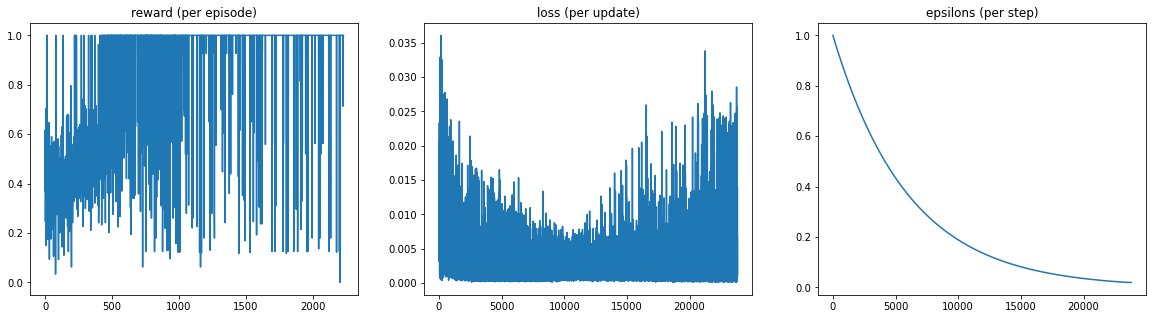

In [8]:
agent.train(num_frames)

## Test

Run the trained agent for 1 episode with $\epsilon=0$.

[ 5.00000000e-01+5.00000000e-01j -1.89843800e-16-2.18358318e-16j
 -1.43114687e-17-1.95156391e-17j -5.55111512e-17-1.90819582e-17j
  1.11022302e-16+6.93889390e-17j  4.16333634e-17+2.77555756e-17j
 -8.32667268e-17-1.66533454e-16j -1.11022302e-16+1.94289029e-16j
  5.00000000e-01-5.00000000e-01j]
score:  1.0000000000000002


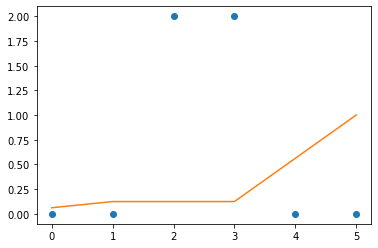

In [9]:
 agent.epsilon = 0
 frames = agent.test()
 import matplotlib.pyplot as plt
 act, QFI = zip(*frames)
 plt.plot(act, 'o')
 plt.plot(QFI)
 plt.show()